# Expectation of 2D Power Spectrum (and its actual covariance)

In this notebook, we aim to derive from first principles the expectation of the 2D power spectrum of foregrounds, specifically in the context of point-source foregrounds (we hope that this is intuitively generalisable to continuous foregrounds). In the process, we find that we require the covariance of the visibility, so that in effect we cover all required elements of the distribution. 

What differentiates this from previous work (in the CHIPS paper and Murray et al. 2017) is that we properly retain the structure of the $(u,v)$-gridding, and therefore retain the covariance between baselines.

For all derivations here we will assume that sources have flat spectra, for simplicity. It should not be difficult to modify this in principle.

We will run through a number of different approximations/special cases to see what effect each has.

Namely, we will consider (listed in basic order of increasing complexity/generality):

* Beam: Uniform, GB frequency-independent or dependent
* Sky Distribution: single-source, non-stochastic uniform sky, stochastic (Poisson) uniform sky
* Baseline layout and UV gridding: infinite baselines + dirac delta gridding, one baseline per square grid cell, infinite baselines + weighted gridding, finite baselines + weighted gridding

The following is the master equation that we shall use for defining a visibility in the presence of many (point) sources:

\begin{equation}
    \tilde{V}(\eta, \mathbf{u}) = \sum_{j=1}^{N_s} \sum_{i=1}^{N_{\rm bl}} S_j \nu_0 \int df \phi(f) e^{-2\pi i \nu_0 f \eta} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}   B(\mathbf{l}_j, \nu) e^{-2\pi i f \mathbf{u}_i \cdot\mathbf{l}_j}.
\end{equation}

Here $W$ is a window function that weights the gridding of visibilities in the UV plane (normalised so that the total weight is unity), $S$ is the flux-density of each source, $B$ is the primary beam, $u_i$ is the baseline length at some reference frequency $\nu_0$, $f$ is the ratio of frequency to the reference, $f=\nu_0/\nu$, $\phi(f)$ is the conjunction of taper and bandpass, and the sum is over all sources and baselines.

The power spectrum itself is an angular average over $\mathbf{u}$. However, it is important to note that the average should take into account the weighting of each $u$ afforded by the baseline layout:

\begin{equation}
    P(\eta, u) = \int_0^{\pi} d\theta \frac{\sum_{i=1}^{N_{\rm bl}} W_0(\mathbf{u} - \mathbf{u}_i)}{\int_0^{\pi} d\theta\sum_{i=1}^{N_{\rm bl}} W_0(\mathbf{u} - \mathbf{u}_i)} \left|\tilde{V}(\eta, \mathbf{u})\right|^2
\end{equation}

Note that this equation neglects the fact that baselines contribute differently to different bins at different frequency, and opts for normalising based on the reference frequency. We can fix that later.

We only integrate over half a circle, since the other half is entirely redundant (any baseline configuration could be rather defined in one half of the UV plane). 

## Utilities

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

from powerbox.dft import fft
from numpy.fft import fftfreq, fft2, fftshift

from spore.mock.foregrounds import GalacticForegrounds
from spore.model.spatial_dist import PureClustering_FlatSky
from spore.model.spectral_index import UniversalDist
from spore.model.beam import CircularGaussian
from spore.model.foregrounds import _cov_fourier

from astropy.constants import k_B


from scipy.special import j1

%load_ext fortranmagic

nu0 = 150.
f = np.linspace(1,1.6/1.5,100)

s0 = 0.2
mu1 = 1

# Find a reasonable range of eta
eta_base_large = fftfreq(1024, d=2./1024.) # Lots of fine channels
eta_base_small = fftfreq(10, d=10./10.) # Few broad channels
eta_base_large = eta_base_large[eta_base_large>0]
eta_base_small = eta_base_small[eta_base_small>0]

eta = np.logspace(np.log10(np.abs(eta_base_small).min()),np.log10(np.abs(eta_base_large).max()), 100)

# Since eta is so close to reasonable eta, make them equivalent
u = eta.copy()

ModuleNotFoundError: No module named 'powerbox'

In [ ]:
def power_from_vis(vis_nu, f, nu0):
    res, eta = fft(nu0 * vis_nu, L = f[-1]- f[0], axes=(0,))
    eta = eta[0]

    res = np.abs(res)**2
    res = res[len(f)/2+1:]
    eta = eta[len(f)/2+1:]
    return res, eta/nu0

def plot_power(power, u, eta, vmin=None, u_is_logscale=True, eta_is_logscale=True):
    if u_is_logscale:
        umin = np.log10(u[0])
        umax = np.log10(u[-1])
    else:
        umin = u[0]
        umax = u[-1]
        
    if eta_is_logscale:
        etamin = np.log10(eta[0])
        etamax = np.log10(eta[-1])
    else:
        etamin = eta[0]
        etamax = eta[-1]
        

    plt.imshow(power,origin='lower', norm=LogNorm(), extent = (umin,umax,etamin,etamax), vmin=vmin)
    plt.xlabel(r"$\log_10 u$")
    plt.ylabel(r"$\eta$")
    
    if not u_is_logscale:
        plt.xscale('log')
    if not eta_is_logscale:
        plt.yscale('log')
        
    plt.colorbar()

## Beam: Top-Hat

In this section, we consider the primary beam, $B(l)$ to be a top-hat out to l=1 (the horizon). 

In this case, the beam disappears:

\begin{align}
    \tilde{V}(\eta, \mathbf{u}) &= \sum_{j=1}^{N_s} \sum_{i=1}^{N_{\rm bl}} S_j \nu_0 \int df e^{-2\pi i \nu_0 f \eta} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)} e^{-2\pi i f \mathbf{u}_i \cdot\mathbf{l}_j}. \nonumber \\
    &= \sum_{j=1}^{N_s} \sum_{i=1}^{N_{\rm bl}} S_j \nu_0 \int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u}_i \cdot\mathbf{l}_j)} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}
\end{align}

### Sky-Distribution: Single-Source

We consider just a single source in the sky, at position $(l_0, m_0)$ and with flux density $S_0$. Thus we have

\begin{equation}
    \tilde{V}(\eta, \mathbf{u}) = \sum_{i=1}^{N_{\rm bl}} S_0 \nu_0 \int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u}_i \cdot\mathbf{l}_0)}\frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}
\end{equation}

#### Gridding: Dirac Delta

If the weighting function is a dirac-delta, then the only way to have anything meaningful arise is by the extremely ideal assumption that there are baselines at *every* UV point. Thus throughout this exploration, a Dirac-Delta gridding will always be assumed to be accompanied by this assumption. 

In this case, the sum over baselines turns into an integral, which then contracts to a single value:

\begin{align}
    \tilde{V}(\eta, \mathbf{u}) &= S_0 \nu_0 \int df e^{-2\pi i (f \nu_0  \eta + \vec{u} \cdot\vec{l}_0)} \nonumber \\
    &= S_0 \nu_0 e^{-2\pi i  \mathbf{u} \cdot\mathbf{l}_0} \int df e^{-2\pi i f \nu_0  \eta} \nonumber \\
    &= S_0 \nu_0 e^{-2\pi i  \mathbf{u} \cdot\mathbf{l}_0} \delta(\nu_0 \eta).
\end{align}

Thus the power-spectrum, $\tilde{V}\tilde{V}^*$ is

\begin{equation}
    P(\eta, u) = S_0^2 \nu_0^2 \delta(\eta).
\end{equation}

Clearly, all of the power is at $\eta = 0$ in such a case. This is most likely due to the "perfect" UV sampling.

While restricting the frequency range to a small finite range will smear out the delta function, it will not induce a wedge, as the integral has no dependence on $u$.

#### Gridding: NGP

In this case, we make a very restrictive assumption. That is, we assume that the UV gridding is done via nearest-grid-point assignment on a rectilinear grid, and furthermore that each baseline belongs to the same grid-cell over the entire bandwidth (i.e. there is a one-to-one relationship between baselines and grid cells). We note that this assumption, with the extra condition that the baselines at $\nu_0$ define the "central value" of each bin,  is precisely that of the "Delay Approximation", so that the frequency transform is over baselines rather than frequencies.

**Note: ** It would be possible to have NGP gridding with arbitrary baseline layouts, but the maths gets a little complicated, so we delay such a calculation for later. In any case, this *shouldn't* be how the calculation is done.

In this case then we have $\mathbf{u}_i = \mathbf{u}$ and $W = 1$:

\begin{equation}
    \tilde{V}(\eta, \mathbf{u}) =  S_0 \nu_0 \int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u} \cdot\vec{l}_0)} = S_0 \nu_0 \delta(\nu_0 \eta + \mathbf{u}\cdot\mathbf{l}_0) e^{-2\pi i \mathbf{u}\cdot\mathbf{l}_0}
\end{equation}


The angular integration is a bit messy here, because "square pegs" don't fit in "round holes". Nevertheless, assuming the annulus we care about neatly captures only bins defined at the same $u$, each bin has the same weight, since exactly one baseline is in each, thus for the power spectrum, we have

$$ P(\eta, u) = S_0^2 \nu_0^2 \frac{1}{2\pi} \int  d\theta \delta(\nu_0\eta + \mathbf{u}\cdot \mathbf{l}_0).$$

Let $\phi$ be the angle between $\mathbf{u}$ and $\mathbf{l_0}$. The argument in the delta is zero when 

$$ \phi = \cos^{-1} \left(-\frac{\nu_0\eta}{u l_0}\right). $$

This only has a solution when

$$ \left|\frac{\nu_0 \eta}{ul_0}\right| \leq 1, $$

So the power spectrum is

$$ P(\eta, u ) = \begin{cases} \frac{S_0^2 \nu_0^2}{2\pi} & \left|\frac{\nu_0 \eta}{ul_0}\right| \leq 1 \\
                               0 & {\rm otherwise} \end{cases}. $$

This perfectly traces out a wedge with slope 1 in the $u-\eta$ plane.

Since this "semi-realistic" example works out so nicely, it is convenient to add some more realism by restricting the bandwidth of the observation. Let $\phi$ be a "taper + bandpass" function, which is 1 at 0. In this exploration, whenever we use this function analytically, it will either be a step function, or a Gaussian for simplicity:

$$ \phi(f) = e^{-f^2/2\tau}. $$

In this case, the visibility is

$$ \tilde{V}(\eta, \mathbf{u}) =  S_0 \nu_0 2 \pi \tau^2 e^{-2\pi^2\tau^2(\nu_0\eta + \mathbf{u}\cdot\mathbf{l}_0)^2} e^{-2\pi i f_: (\nu_0\eta + \mathbf{u}\cdot\mathbf{l}_0)}, $$

where $f_:$ is the central frequency of the band (as a ratio to $\nu_0$). The power spectrum is thus

$$ P(\eta, u) = S_0^2 \nu_0^2 2\pi \tau^4 \int  d\theta e^{-2\pi^2\tau^2(\nu_0\eta + \mathbf{u}\cdot\mathbf{l}_0)^2}.$$

As far as I can tell, there is no analytic solution to this, however, we can see the general trend of the solution by looking at limits in $u$ and $l$. 

Clearly, if $l$ is 0, then there is no $u$ dependence, and thus there is no wedge. For $l>0$ and rising, the effect of the $u$ dependence becomes stronger. 

For $u \rightarrow \infty$, the power is constant for all $\eta$ (i.e. it fills the whole space), but for $u\rightarrow 0$, the power has an exponential drop-off dependent on the parameters of the instrument (i.e. power is contained to low $\eta$). Thus we see that something like a wedge will occur, but it will not be as obvious as in the infinite-frequency case.

#### Gridding: Weighted Gridding

I think the only real weighted gridding worth looking at is where the weights are given by the Fourier-space beam kernel. In this case, the fourier-space beam is a delta-function, so we really have covered this question already. However, here we have a finite number of baselines. In this case, it is extremely unlikely to ever get a baseline precisely matching the gridded $u$, so typically the visibility will be zero.

For this reason, a derivation of the weighted gridding is deferred until the Gaussian Beam.

### Sky-Distribution: Non-Stochastic Uniform

Now we consider a continuous distribution of sources which has constant brightness across the sky. This is the same as an infinitely deep sum of sources as in the previous section.

\begin{equation}
    \tilde{V}(\eta, \mathbf{u}) = \sum_{i=1}^{N_{\rm bl}} \bar{S} \nu_0 \int d^2\mathbf{l} \int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u}_i \cdot\mathbf{l})} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}
\end{equation}

Immediately performing the integral over $\mathbf{l}$, we have 

\begin{equation}
    \tilde{V}(\eta, \mathbf{u}) = \sum_{i=1}^{N_{\rm bl}} \bar{S} \nu_0 \int df \frac{J_1(2\pi fu_i)}{fu_i}e^{-2\pi i f \nu_0  \eta} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}
\end{equation}

#### Gridding: Dirac Delta

If the weighting function is a dirac-delta, but we have baselines at every UV point, then the sum over baselines turns into an integral, which then contracts to a single value:

\begin{align}
    \tilde{V}(\eta, \mathbf{u}) &= \bar{S} \nu_0 \frac{J_1(2\pi u)}{u} \int df e^{-2\pi i  f \nu_0  \eta} \nonumber \\
    &= S_0 \nu_0 \frac{J_1(2\pi u)}{u} \delta(\nu_0 \eta) \nonumber \\
\end{align}

In this case, the integral over $\theta$ is very simple, as there is no $\theta$ dependence:

\begin{equation}
    P(\eta, u) = S_0^2 \nu_0^2 \frac{J_1^2(2\pi u)}{u^2}\delta(\eta).
\end{equation}

Clearly, all of the power is at $\eta = 0$, again because we are not mixing frequencies.

#### Gridding: NGP

(See corresponding section under single-source dist. for details of assumptions here).

In this case then we have $\mathbf{u}_i = \mathbf{u}$ and $W = 1$:

\begin{equation}
    \tilde{V}(\eta, u) = \bar{S} \nu_0 \int df \frac{J_1(2\pi fu)}{fu}e^{-2\pi i f \nu_0  \eta}
\end{equation}


Here the finitude of the bandwidth is quite important. I will not attempt to do the analytic calculation using gaussian $\phi$, as it is doomed to failure. However, we can do it numerically.

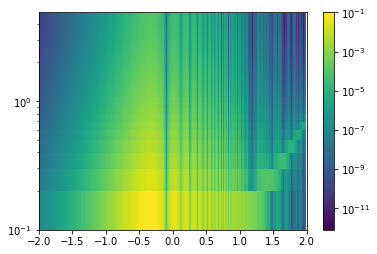

In [42]:
sbar = 1
fu = np.outer(f,u)

fnc = j1(2*np.pi*fu)/fu

power_th_ns_1b, eta = power_from_vis(sbar*fnc, f, nu0)
plot_power(power_th_ns_1b, u, eta)

This plot has a kind of "wedge" but it is not very highlighted. If instead we had integrated over a wider range of f:

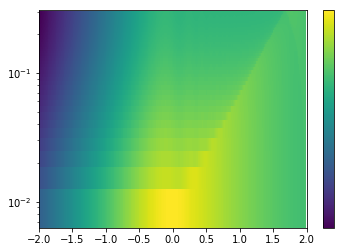

In [44]:
sbar = 1
ff = np.linspace(0.001,1.6/1.5, 100)

fu = np.outer(ff,u)

fnc = j1(2*np.pi*fu)/fu

power_th_ns_1b_ff, eta = power_from_vis(sbar*fnc, ff, nu0)
plot_power(power_th_ns_1b_ff, u, eta)

Here the wedge is a lot clearer. We could have done a symmetric range of $f$ (though it would have been unphysical):

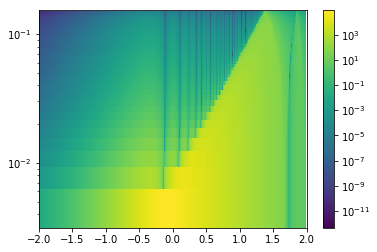

In [45]:
sbar = 1
ff = np.linspace(-1.6/1.5,1.6/1.5, 100)

fu = np.outer(ff,u)

fnc = j1(2*np.pi*fu)/fu

power_th_ns_1b_ff, eta = power_from_vis(sbar*fnc, ff, nu0)
plot_power(power_th_ns_1b_ff, u, eta)

#### Gridding: Weighted

Refer to previous section on this -- it is trivially zero because the weight function is delta.

### Sky-Distribution: Stochastic  Uniform

When the sky is stochastic, we can only compute the exact power-spectrum for a *realisation* of the sky, which is not that helpful. However, we can do better than this by computing the *expectation* of the power spectrum for a given sky model. In this case, we consider only a sky with Poisson-distributed point sources which are uniformly distributed.

The first thing to realise is that the expectation of the power spectrum is

\begin{equation}
    \langle P(\eta, \mathbf{u}) \rangle = \langle \tilde{V} \tilde{V}^* \rangle = \langle \tilde{V} \rangle \langle \tilde{V}^* \rangle + {\rm Var}(\tilde{V}).
\end{equation}

The first term on the RHS is precisely what we have calculated in the previous sections (for this beam type), but we need to also calculate the second term.

Note that the initial equation for $P(\eta, u)$ involves averaging over weighted values of $P(\eta, \mathbf{u})$. Since the weights themselves are not stochastic (since we are given a set of baselines and grid-points), the expectation of the averaged power is merely the weighted sum of the expectation of the binned-power above.

Here we go slightly further than what is done in Murray et al. (2017). There, the covariance *between frequencies* for the *same baseline* is determined. Here, we desire the variance of a single *bin* in $(\eta, u)$-space. The variance of a sum is merely the sum of covariance of all pairs. The only stochastic part is $dN/dS$, and so we may take the covariance operator through to there, bringing everything else out. The source counts are independent for different bins of $S$ and $l$, but are not independent over $\nu$ or baselines. Ultimately, we end up with 

\begin{align}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = &\sum_{i_1=1}^{N_{\rm bl}}\sum_{i_2=1}^{N_{\rm bl}} \nu_0^2 \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \frac{W'(\mathbf{u} - f'\mathbf{u}_{i_1}) W''(\mathbf{u} - f''\mathbf{u}_{i_2})}{\sum_{k=1}^{N_{\rm bl}}W'(\mathbf{u} - f' \mathbf{u}_k)\sum_{k=1}^{N_{\rm bl}}W''(\mathbf{u} - f'' \mathbf{u}_k)} \nonumber \\
    &\times \mu_2 \int d^2\mathbf{l} B'B'' e^{-2\pi i \mathbf{l}\cdot (f' \mathbf{u}_{i_1} -f'' \mathbf{u}_{i_2})}.
\end{align}

This is a fairly involved expression, and clearly it is numerically expensive -- ultimately it is 6-dimensional sum for each $\eta$ and $u$. Furthermore, it is only applicable to spatially uncorrelated sky models. 

While we will always try to solve this equation explicitly if possible, most choice for $B$ and $W$ do not admit analytic solutions. In this case it is more numerically feasible to use the following identity. If $\mathbf{y} = \mathbf{F}\mathbf{x}$, then:

$$ {\rm Cov}(\mathbf{y}) = \mathbf{F}^\dagger {\rm Cov}(\mathbf{x}) \mathbf{F}.$$

Letting $\mathbf{F}$ be the DFT matrix, then the covariance of $\tilde{V}$ can be found using the above relation on $V$. 

In this case, where the beam is a top-hat, it can be removed and the integral over $\mathbf{l}$ performed immediately:

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \sum_{i_1=1}^{N_{\rm bl}}\sum_{i_2=1}^{N_{\rm bl}} \mu_2 \nu_0^2 \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \frac{W'(\mathbf{u} - f'\mathbf{u}_{i_1}) W''(\mathbf{u} - f''\mathbf{u}_{i_2})}{\sum_{k=1}^{N_{\rm bl}}W'(\mathbf{u} - f' \mathbf{u}_k)\sum_{k=1}^{N_{\rm bl}}W''(\mathbf{u} - f'' \mathbf{u}_k)} \frac{J_1(2\pi |f'\mathbf{u}_{i_1} -f'' \mathbf{u}_{i_2}|)}{|f'\mathbf{u}_{i_1} -f'' \mathbf{u}_{i_2}|}.
\end{equation}

#### Gridding: Dirac-Delta

If the weighting function is a dirac-delta, but we have baselines at every UV point, then the sum over baselines turns into an integral, which then contracts to a single value. The argument of the bessel function goes to zero, and at that point, its ratio goes to $\pi$. 

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \pi \mu_2 \nu_0^2 \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta}
\end{equation}

Each of the integrals over frequency becomes a delta function (**note: this only occurs for an infinite bandwidth**), which merely reduces to:

$$  {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \pi \mu_2 \nu_0^2 \delta(\eta). $$

Thus the total power-spectrum is
\begin{equation}
    P(\eta, u) = \left(\pi\mu_2 + \mu_1^2\frac{J_1^2(2\pi u)}{u^2} \right) \nu_0^2 \delta(\eta).
\end{equation}

Clearly, all of the power is at $\eta = 0$ in such a case. Thus, in the most general sense, the lack of mixing of frequencies leads to a lack of wedge.

#### Gridding: NGP

(See corresponding section under single-source dist. for details of assumptions here).

In this case then we have $\mathbf{u}_i = \mathbf{u}$ and $W = 1$:

\begin{equation}
    {\rm Var}\left(\tilde{V}(\nu, \mathbf{u})\right) = \pi \mu_2 \nu_0^2 \frac{J_1(2\pi f_\nu u) }{f_\nu u}
\end{equation}


Again, the finitude of the bandwidth is quite important. Note also that the variance depends solely on $u$, and so the angular average is very simple.

In [61]:
def jinc(x):
    if np.abs(x) < 1e-8:
        return 0.5
    else:
        return j1(x)/x
    
jinc = np.vectorize(jinc)

(300, 49, 49)
(49, 300)


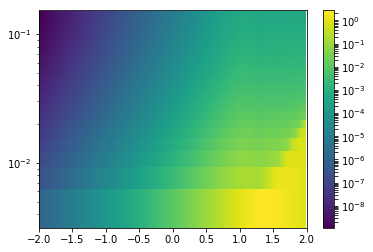

In [67]:
mu2 = 1

fnu = np.add.outer(f,-f)
ufnu = np.einsum("i,jk -> ijk", u, fnu)

cov_nu = np.pi* mu2 * nu0**2 * 2*np.pi * jinc(2*np.pi*ufnu)
cov_eta = _cov_fourier(cov_nu, dx = f[1]-f[0])
cov_eta = np.diagonal(cov_eta.T).T

plot_power(cov_eta, u, eta)

The variance has a definite wedge. When plotting in conjunction with the expectation part:

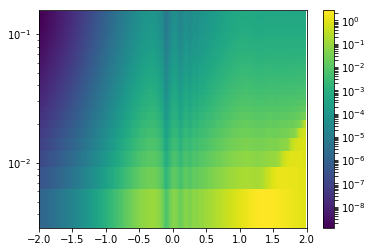

In [69]:
plot_power(cov_eta+power_th_ns_1b, u, eta)

#### Gridding: Weighted

This can again be neglected in this section.

## Beam: Frequency-Independent Gaussian

For this entire section, we will consider the primary beam to be

$$ B(l) = e^{-l^2/2\sigma^2}. $$

In this case we can take the extent of $l$ to be infinite, since the beam truncates things nicely (in practice, this beam cannot be true, nor can objects exist at $l>1$). 

In this case, the beam comes outside the $\nu$ integral:

\begin{align}
    \tilde{V}(\eta, \mathbf{u}) &= \sum_{j=1}^{N_s} \sum_{i=1}^{N_{\rm bl}} S_j B(l_j) \nu_0 \int df e^{-2\pi i \nu_0 f \eta} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)} e^{-2\pi i f \mathbf{u}_i \cdot\mathbf{l}_j}. \nonumber \\
    &= \sum_{j=1}^{N_s} \sum_{i=1}^{N_{\rm bl}} S_j B(l_j) \nu_0 \int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u}_i \cdot\mathbf{l}_j)} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}
\end{align}

### Sky-Distribution: Single-Source

We consider just a single source in the sky, at position $(l_0, m_0)$ and with flux density $S_0$. Thus we have

\begin{equation}
    \tilde{V}(\eta, \mathbf{u}) = \sum_{i=1}^{N_{\rm bl}} S_0 \nu_0 B(l_0)\int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u}_i \cdot\mathbf{l}_0)} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}
\end{equation}

#### Gridding: Dirac Delta

It is clear from the top-hat section that this will not yield a wedge.

#### Gridding: NGP

We refer back to the corresponding top-hat beam section for this, as the only difference is that the power is further weighted by a beam squared at $l_0$. That is, the wedge is very clear.

#### Gridding: Weighted *

Since this is the first time that we have encountered a weighting function that is useful, we will here derive the basic equations. We will exclusively use a weighting function which is proportional to the the fourier beam kernel:

$$ W \propto \hat{B}. $$

In this single-source case we have

\begin{equation}
    \tilde{V}(\eta, \mathbf{u}) = \sum_{i=1}^{N_{\rm bl}} S_0 \nu_0 B(l_0)\int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u}_i \cdot\mathbf{l}_0)} \frac{\hat{B}(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}\hat{B}(\mathbf{u} - f \mathbf{u}_k)}
\end{equation}

Without knowing precisely where the baselines are, there is not much more that can be done here. The frequency transform includes the sum of beam kernels, which are dependent on the frequency and also the baseline layout.

There is the possibility to specify in some way the baseline layout here, but for simplicity we will defer doing so until the next section, in which the sky itself is considered to be symmetric, which simplifies many of the calculations.

### Sky-Distribution: Non-Stochastic Uniform

Here we start with:

\begin{equation}
    \tilde{V}(\eta, u) = \sum_{i=1}^{N_{\rm bl}} \bar{S} \nu_0 \int d^2\mathbf{l} B(l) \int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u}_i \cdot\mathbf{l})} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}
\end{equation}

Immediately performing the integral over $\mathbf{l}$, we have 

\begin{equation}
    \tilde{V}(\eta, u) = \sum_{i=1}^{N_{\rm bl}} \bar{S} \nu_0 \int df \hat{B}(fu_i) e^{-2\pi i f \nu_0  \eta} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)},
\end{equation}

where 

$$ \hat{B}(fu_i) = y^2 e^{-\pi y^2 f^2 u_i^2}, $$

with $y^2 = 2 \pi \sigma^2$.

#### Gridding: Dirac Delta

It is clear from the top-hat case that this cannot exhibit a wedge.

#### Gridding: NGP

(See corresponding section under single-source dist. for details of assumptions here).

In this case then we have $\mathbf{u}_i = \mathbf{u}$ and $W = 1$:

\begin{equation}
    \tilde{V}(\eta, u) = \bar{S} y^2 \nu_0 \int df   e^{-\pi y^2 f^2 u^2}e^{-2\pi i f \nu_0  \eta}
\end{equation}


Again, here the finitude of the bandwidth is actually quite important.

We will do three things. Firstly, the entire transform just leaves a Gaussian:

\begin{equation}
    \tilde{V}(\eta, u) = \mu_1  \frac{\nu_0}{u^2} e^{-\pi \frac{\nu_0^2 \eta^2}{y^2u^2}},
\end{equation}

with power spectrum:

\begin{equation}
    P(\eta, u) = \mu^2_1  \frac{\nu^2_0}{u^4} e^{-2\pi \frac{\nu_0^2 \eta^2}{y^2u^2}}.
\end{equation}

This definitely has a wedge, provided by the $\eta/u$ in the exponent of the power. 

Now let $\phi$ be a step function. 

Then the power is

$$ P(\eta, u) = \bar{S}^2 y^4 \nu_0^2 \frac{\exp\left(-2\pi (\nu_0 \eta/ y u)^2 \right)}{4\pi y^2 u^2} \left|{\rm erf}\left.\left(i\sqrt{\pi} \frac{\nu_0\eta}{yu} + \sqrt{\pi} y u f\right)\right|_{f_{\rm min}}^{f_{\rm max}}\right|^2. $$

Now let $\phi$ be a Gaussian,  with width $\tau$ in $f$. Then the power is

\begin{equation}
    P(\eta, u) = \frac{\mu_1^2 \pi y^4 \nu_0^2}{1/2\tau^2 + \pi y^2 u^2} \exp\left(-\frac{1}{\pi y^2 u^2 + 1/2\tau^2}\left(\omega^2/2 + \pi y^2u^2 f_:^2/\tau^2 \right)\right)
\end{equation}

where $f_:$ is the central frequency of the band, $\omega = 2\pi \nu_0 \eta$ and $y = 2\pi \sigma^2$.

Particularly when we use a Gaussian taper, we can see the behaviour of the system. For instance, if $\tau \rightarrow \infty$ (i.e. the bandwidth becomes infinite), then the power spectrum follows the same kind of spectrum as the infinite transform above, which shows a clear wedge (i.e. the $\eta/u$ in the exponent).

Conversely, if $\tau \rightarrow 0$, then the entire power goes to zero, but it does so more and more without a wedge (see plot below).

In [9]:
def power_gb_nss_ngp_gt(tau, mu1, sigma, fmid, eta, u):
    y2 = 2*np.pi*sigma**2
    x2 = np.pi*y2*u**2
    w = 2*np.pi*nu0*eta
    
    z2 = x2 + 1./(2*tau**2)
    
    "Power spectrum with Gaussian Beam, non-stochastic sky, nearest-grid-point gridding, and gaussian taper"
    prefac = mu1**2 * np.pi * y2**2 * nu0**2/z2
    
    exppart = np.exp(-np.add.outer(w**2/2 , x2*fmid**2/tau**2)/z2)
    out = exppart * prefac
    return out


def test_power_gb_nss_ngp_gt(tau, mu1, sigma, fmid):
    "Calculates the power spectrum numerically"
    
    nsig = 3 #Width is twice this
    ntau = 2
    
    fvec = np.arange(fmid-ntau*tau, fmid+ntau*tau, 2*ntau*tau/256)
    l0 = np.arange(-sigma*nsig, sigma*nsig, 2*nsig*sigma/256)
    
    L0, M0 = np.meshgrid(l0,l0)
    L2 = L0**2 + M0**2
    
    vis_u = np.zeros((len(fvec), len(l0)/2-1))
    for i,f in enumerate(fvec):
        # The following works by transformation of variables, x = fl.
        sky = mu1*np.exp(-(L2/f**2)/(2*sigma**2))
        vis, u = fft(sky, L = 2*nsig*sigma, a= 0, b = 2*np.pi)
        
        vis_u[i] = np.abs(vis[len(l0)/2, len(l0)/2+1:]) / f**2 # Divide by f**2 due to transformation
        
            
    u = u[0][len(l0)/2+1:]
    
    
    # Add bandpass filter
    vis_u2 = (np.exp(-(fvec-fmid)**2/(2*tau**2)) * vis_u.T).T
    vis_eta, eta = fft(vis_u2, L = 2*ntau*tau, axes=(0,), a= 0, b = 2*np.pi)
    
    vis_eta = vis_eta[len(fvec)/2+1:]
    eta = eta[0][len(fvec)/2+1:]
    
    return np.abs(vis_eta)**2, u, eta, fvec, vis_u, vis_u2, sky

def visu_to_powereta(vis_u, fvec, fmid):
    vis_u = (np.exp(-(fvec-fmid)**2/(2*tau**2)) * vis_u.T).T
    vis_eta, eta = fft(vis_u, L = (fvec[-1]-fvec[0]), axes=(0,), a= 0, b = 2*np.pi*nu0)
    
    vis_eta = vis_eta[len(fvec)/2+1:] * np.sqrt(nu0)
    eta = eta[0][len(fvec)/2+1:]
    
    return np.abs(vis_eta)**2, eta

0.166666666667


(1e-20, 1.6807026552481347e+64)

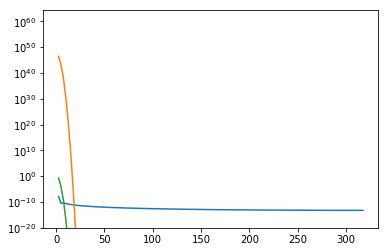

In [313]:
print(u[0])
plt.plot(eta, power[:,11])
plt.plot(eta,  power_gb_nss_ngp_gt(tau, mu1, sigma, fmid, eta, u[0]))
plt.plot(eta, 2*tau**2*mu1**2*y2**2*nu0**2*np.pi*np.exp(-(2*np.pi*nu0*eta)**2*tau**2))
plt.yscale('log')
plt.ylim(1e-20)

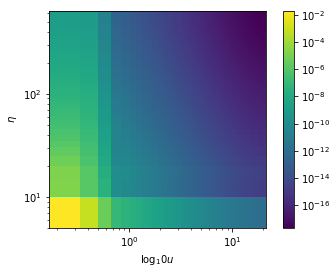

In [31]:
nu0 = 1.
mu1 = 1.
sigma = 1.
tau = 0.05
fmid=1.

y2 = 2*np.pi*sigma**2

power, u , eta, fvec, vis_u, vis_u2, sky = test_power_gb_nss_ngp_gt(tau, mu1, sigma, fmid)
plot_power(power, u, eta,  u_is_logscale=False, eta_is_logscale=False)

(3.7773020782912097e-13, 285746540310.98993)

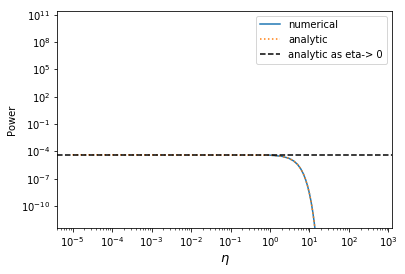

In [36]:
u = 1.
nu0 = 1.
mu1 = 1.
sigma = 0.1
tau = 0.05
fmid=1.
fvec = np.linspace(fmid-10*tau, fmid+10*tau, 1024)
y2 = 2*np.pi*sigma**2


visu = mu1 * y2 * np.exp(-np.pi*y2*fvec**2 * u**2 ) 
power, eta = visu_to_powereta(visu, fvec, fmid) 


plt.plot(eta, power, label="numerical")

eta = np.concatenate(([1e-5], eta))
x2 = np.pi*y2*u**2
w = 2*np.pi*nu0*eta


plt.plot(eta,  power_gb_nss_ngp_gt(tau, mu1, sigma, fmid, eta, u), ls=":", label="analytic")
plt.axhline((mu1*y2*nu0*np.sqrt(np.pi)* tau * np.exp(-fmid**2*x2/(2*x2*tau**2 + 1))/np.sqrt(x2*tau**2 +0.5))**2, color='k', ls='--',
           label="analytic as eta-> 0")

if tau > 0.5:
    plt.plot(eta, mu1**2 * y2**2 *nu0**2 *np.pi * np.exp(-w**2/(2*x2))/x2, color='c', ls='--', label='analytic as tau->Inf')
    plt.axhline(mu1**2 * y2 * nu0**2/u**2, color='k', ls=':', label="Analytic as tau-> Inf and eta->0")

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\eta$",fontsize=13)
plt.ylabel("Power")
plt.ylim(power.max()/1e8,)

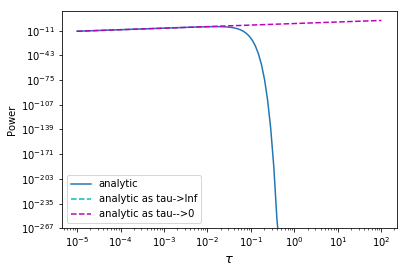

In [30]:
# PLOT VS TAU
nu0 = 1.
mu1 = 1.
sigma = 0.1
tau = np.logspace(-5,2, 100)
fmid=1.

y2 = 2*np.pi*sigma**2
u = 1.
eta = 10.


x2 = np.pi*y2*u**2
w = 2*np.pi*nu0*eta


plt.plot(tau,  power_gb_nss_ngp_gt(tau, mu1, sigma, fmid, eta, u), label="analytic")
#plt.axhline((mu1*y2*nu0*np.sqrt(np.pi)* tau * np.exp(-fmid**2*x2/(2*x2*tau**2 + 1))/np.sqrt(x2*tau**2 +0.5))**2, color='k', ls='--',
 #          label="analytic as eta-> 0")

plt.axhline(mu1**2 * y2**2 *nu0**2 *np.pi * np.exp(-w**2/(2*x2))/x2, color='c', ls='--', label='analytic as tau->Inf')
plt.plot(tau, 2*tau**2*np.pi*mu1**2*y2**2*nu0**2*np.exp(-2*x2*fmid**2),color='m',ls='--', label="analytic as tau-->0")

if eta < 1e-3:
    plt.axhline(mu1**2 * y2 * nu0**2/u**2, color='k', ls=':', label="Analytic as tau-> Inf and eta->0")


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\tau$",fontsize=13)
plt.ylabel("Power")
#plt.ylim(power.max()/1e8,)

#### Gridding: Weighted *

Here we have:

\begin{equation}
    \tilde{V}(\eta, u) = \sum_{i=1}^{N_{\rm bl}} \bar{S} \nu_0 \int df  e^{-2\pi i f \nu_0  \eta} \frac{\hat{B}(fu_i) \hat{B}(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}\hat{B}(\mathbf{u} - f \mathbf{u}_k)},
\end{equation}




Again, we cannot get any further than this without specifying some kind of baseline layout.

##### Baseline Layout: Sparse *

We first mention this special case, in which we assume that the baselines are extremely sparse, so that typically only one baseline ever contributes to any ring of $u$, and it contributes at the point closest to $u$. This is of course quite unrealistic. It gives an answer which is precisely the same as the NGP case above *for the u at which baselines are situated*. In between these points, the form will be the same (in the $\eta$ direction) but the result will be damped according to how far from $u$ the nearest baseline is. This will most likely contribute a "ringing" to the $u$-direction signal.

##### Baseline Layout: Symmetric Gaussian

The most general case that can be derived analytically is that of a circularly-symmetric Gaussian distribution of baselines, in the continuous limit.

** Justification: ** There's a temptation to think that perhaps doing this is equivalent to the general solution. The reasoning goes like this: given that we have an isotropic sky, with isotropic response (beam), then we expect the actual power at any $\mathbf{u}$ to be only dependent on $u$. So we average over annuli to get the final result. The only asymmetry that may enter with this setup is the asymmetry of the baseline layout. However, since we are averaging over annuli in $u$, we may reason that differences in $V(\mathbf{u})$ for the same $u$ but different angles, will be averaged out. This fact *will* ensure that rotating the baselines about the origin has no effect. However it does *not* ensure that clumpiness of baselines has no effect. This is because of the coherent/incoherent averaging problem. Since the transformation to power uses a squaring operation, we know that the sum of squares is not the same as the square of a sum, in general. 


Let the baseline layout (number density) be 

$$\rho(u_i) \propto e^{-u_i^2/2\sigma_u^2}. $$

Then the sum over baselines may be converted to an integral:

\begin{equation}
    \tilde{V}(\eta, u) = \bar{S} \nu_0 \int df \phi(f-f') e^{-2\pi i f \nu_0  \eta} \int d^2\mathbf{u}_i e^{-u_i^2/2\sigma_u^2} \frac{\hat{B}(fu_i) \hat{B}(\mathbf{u} - f \mathbf{u}_i)}{\int d^2\mathbf{u}_i e^{-u_i^2/2\sigma_u^2}\hat{B}(\mathbf{u} - f \mathbf{u}_k)}.
\end{equation}

It is tempting to transform the $\mathbf{u}_i$-integral to polar co-ordinates, but we realise that for a single $\mathbf{u}$, the integral is not circularly symmetric. Rather, since $\hat{B}$ is a Gaussian, it is easier to integrate each Cartesian co-ordinate independently.

We start with the integral in the denominator and find

$$\int d^2\mathbf{u}_i e^{-u_i^2/2\sigma_u^2}\hat{B}(\mathbf{u} - f \mathbf{u}_k) = e^{-\pi y^2 u^2}\left(\frac{\pi}{1/2\sigma_u^2 + \pi y^2f^2}\right)\exp\left(\frac{\pi^2y^4f^2u^2}{1/2\sigma_u^2 + \pi y^2f^2}\right). $$

Clearly, the upper integral is very similar, and we finally find that

\begin{equation}
    \tilde{V}(\nu, u) = \bar{S} \nu_0 y^2 \frac{1 + 2\pi \sigma_u^2 y^2f^2}{1+4\pi \sigma_u^2 y^2 f^2} \exp\left(2\pi^2 \sigma_y^2 y^4 f^2 u^2\left(\frac{1}{1 + 4\pi\sigma_u^2y^2f^2} + \frac{1}{1 + 2\pi \sigma_u^2y^2f^2}\right)\right).
\end{equation}

Defining $ q^2_\nu = 2\pi \sigma_u^2 y^2 f^2$, this simplifies to

\begin{equation}
    \tilde{V}(\nu, u) = \bar{S} \nu_0 y^2 \frac{1 + q^2_\nu}{1+2q^2_\nu} \exp\left(q^2_\nu y^2 u^2\left(\frac{1}{1 + 2q^2_\nu} - \frac{1}{1 + q^2_\nu}\right)\right).
\end{equation}

This clearly has a negative exponential as a function of $u$. 

If $q^2_\nu \rightarrow \infty$, (i.e. the beam is very broad, or the baseline distribution is very wide), then we are left with

\begin{equation}
    \tilde{V}(\nu, u) \approx \frac{\bar{S} \nu_0 y^2}{2} \exp\left(- y^2 u^2/2\right),
\end{equation}

which has no frequency-dependence left, unless the beam itself is frequency-dependent (more on that in the next big section).

Moreover, if $q_\nu^2 \rightarrow 0$, then the visibility is just a constant, $\bar{S}\nu_0 y^2$. Neither of these limits will produce a wedge. Unfortunately, it is very difficult to solve the $f$ integral in the full case. 

We just do it numerically:

In [77]:
def Vnu(y2, su2, mu1, f, u):
    q = 2*np.pi*su2*y2
    
    p1 = 1+q*f**2
    p2 = 1+2*q*f**2

    prefac =  mu1*nu0*y2 * p1/p2
    exppart = np.exp(np.outer(u**2, q*y2*f**2*(1/p2-1/p1)))
    
    return (prefac*exppart).T

Foran MWA-like setup, we have $y^2 \approx 0.25$ and $\sigma_u\approx 40.$:

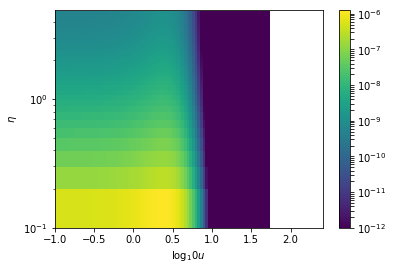

In [81]:
vis_nu = Vnu(0.25, 1600., mu1, f, u) 
power, eta = power_from_vis(vis_nu, f, nu0)
plot_power(power,u,eta,vmin=1e-12)

For a smaller beam (i.e. SKA-like):

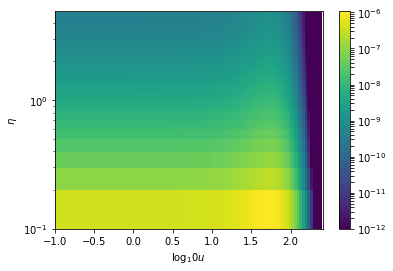

In [83]:
vis_nu = Vnu(0.025**2, 1600., mu1, f, u) 
power, eta = power_from_vis(vis_nu, f, nu0)
plot_power(power,u,eta,vmin=1e-12)

There is a slight wedge here, but it is very damped. This may be because of the infinite layout, *or* it may be because the sky is completely uniform. This second assumption we'll tackle next.

### Sky-Distribution: Stochastic  Uniform

** See the Top-Hat section corresponding to this to see the derivation of the basic equations **

In this case, where the beam is a gaussian, it can be removed and the integral over $\mathbf{l}$ performed immediately:

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \sum_{i_1=1}^{N_{\rm bl}}\sum_{i_2=1}^{N_{\rm bl}} \frac{\mu_2 \nu_0^2 y^2}{2} \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \frac{W'(\mathbf{u} - f'\mathbf{u}_{i_1}) W''(\mathbf{u} - f''\mathbf{u}_{i_2})}{\sum_{k=1}^{N_{\rm bl}}W'(\mathbf{u} - f' \mathbf{u}_k)\sum_{k=1}^{N_{\rm bl}}W''(\mathbf{u} - f'' \mathbf{u}_k)} \exp\left[-\pi^2 \sigma^2(f'\mathbf{u}_{i_1} -f'' \mathbf{u}_{i_2})^2)\right].
\end{equation}

#### Gridding: Dirac Delta

It is clear that this will end up with a dirac function at $\eta = 0$ (see top-hat corresponding section).

#### Gridding: NGP

(See corresponding section under single-source dist. for details of assumptions here).

In this case then we have $\mathbf{u}_i = \mathbf{u}$ and $W = 1$, and since the original baselines *must* be $\mathbf{u}$, we have:

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \pi \mu_2 \sigma^2 \nu_0^2 \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} e^{-\sigma^2 f_\nu^2 u^2},
\end{equation}

with $f_\nu = f'-f''$.

It is worth deriving this case fully for a gaussian taper/bandpass. The algebra gets a little tedious, but we can use Wolfram|Alpha as a two-step process to get the doube integral.

We let $q^2 = \sigma^2 u^2$,and $\omega = 2\pi \nu_0\eta$, for clarity, and find 

$$ Var(V) = \frac{2\pi^2 \mu_2 \sigma^2 \nu_0^2 \tau^2}{\sqrt{4q^2\tau^2 + 1}} \exp\left(-\frac{\tau^2 \omega^2}{4q^2 \tau^2 + 1}\right). $$

#### Gridding: Weighted

We begin with

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \sum_{i_1=1}^{N_{\rm bl}}\sum_{i_2=1}^{N_{\rm bl}} \frac{\mu_2 \nu_0^2 y^2}{2} \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \frac{\hat{B}(\mathbf{u} - f'\mathbf{u}_{i_1}) \hat{B}(\mathbf{u} - f''\mathbf{u}_{i_2})}{\sum_{k=1}^{N_{\rm bl}}\hat{B}(\mathbf{u} - f' \mathbf{u}_k)\sum_{k=1}^{N_{\rm bl}}\hat{B}(\mathbf{u} - f'' \mathbf{u}_k)} \exp\left[-\sigma^2(f'\mathbf{u}_{i_1} -f'' \mathbf{u}_{i_2})^2)\right],
\end{equation}

with $\hat{B} \propto e^{-\pi y^2 u^2}$.

##### Baseline Layout: Symmetric Gaussian

Let the baseline layout (number density) be 

$$\rho(u_i) \propto e^{-u_i^2/2\sigma_u^2}. $$

Then the sum over baselines may be converted to an integral.

Again the integral in the denominator is:

$$\int d^2\mathbf{u}_i e^{-u_i^2/2\sigma_u^2}\hat{B}(\mathbf{u} - f \mathbf{u}_i) = e^{-\pi y^2 u^2}\left(\frac{\pi}{1/2\sigma_u^2 + \pi y^2f^2}\right)\exp\left(\frac{\pi^2y^4f^2u^2}{1/2\sigma_u^2 + \pi y^2f^2}\right). $$

The total denominator is merely the square of this. The next integral to perform is the outer $u$ integrals:

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \frac{\mu_2 \nu_0^2 y^2}{2e^{-2\pi y^2 u^2}\left(\frac{\pi}{1/2\sigma_u^2 + \pi y^2f^2}\right)^2 \exp\left(\frac{2 \pi^2y^4f^2u^2}{1/2\sigma_u^2 + \pi y^2f^2}\right)} \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \int d^2\mathbf{u}_{i_1} \int d^2\mathbf{u}_{i_2} \exp\left[-\left(\frac{u_{i_1}^2+u_{i_2}^2}{2\sigma_u^2}  + \pi y^2 \left((\mathbf{u} - f'\mathbf{u}_{i_1})^2 + (\mathbf{u} - f''\mathbf{u}_{i_2})^2\right) + \sigma^2(f'\mathbf{u}_{i_1} -f'' \mathbf{u}_{i_2})^2\right)\right].
\end{equation}

My calculations (on paper) lead to a result of:


\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \frac{\mu_2 \nu_0^2 y^2}{2 e^{-2\pi y^2 u^2}\left(\frac{\pi}{1/2\sigma_u^2 + \pi y^2f'^2}\right)\left(\frac{\pi}{1/2\sigma_u^2 + \pi y^2f''^2}\right) \exp\left(\frac{2 \pi^2y^4f'^2u^2}{1/2\sigma_u^2 + \pi y^2f'^2}\right)\exp\left(\frac{2 \pi^2y^4f''^2u^2}{1/2\sigma_u^2 + \pi y^2f''^2}\right)}  \frac{4\pi^2\sigma_u^4}{z^2} \exp\left[-\frac{2\pi y^2 u^2 (q^2 - 4\pi y^2 f'f" \sigma^2\sigma_u^2 + 2\sigma^2\sigma_u^2(q^2 - \pi y^2\sigma_u^2)(f'^2+f''^2)}{z^2}\right],
\end{equation}

with $q^2 = 1+2\pi \sigma_u^2 y^2$ and $z^2 = q^2[q^2+2\sigma_u^2\sigma^2(f'^2+f''^2)]$.

Simplifying a little, we get

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \frac{2\mu_2 \nu_0^2 y^2\sigma_u^4\left(1/2\sigma_u^2 + \pi y^2f'^2\right)\left(1/2\sigma_u^2 + \pi y^2f''^2\right)}{z^2 \exp\left(-2\pi y^2 u^2 \left[1 - \frac{\pi y^2f'^2}{1/2\sigma_u^2 + \pi y^2f'^2} - \frac{ \pi y^2 f''^2}{1/2\sigma_u^2 + \pi y^2f''^2} -\frac{q^2 - 4\pi y^2 f'f" \sigma^2\sigma_u^2 + 2\sigma^2\sigma_u^2(q^2 - \pi y^2\sigma_u^2)(f'^2+f''^2)}{z^2}\right]\right)}.
\end{equation}

## Beam: Frequency-Dependent Gaussian

For this entire section, we will consider the primary beam to be

$$ B(l) = e^{-l^2 f^2/ 2\sigma^2}, $$

where $\sigma$ is the beam width at $\nu_0$.

### Sky-Distribution: Single-Source

TODO!!!!!!

We consider just a single source in the sky, at position $(l_0, m_0)$ and with flux density $S_0$. Thus we have

\begin{equation}
    \tilde{V}(\eta, \mathbf{u}) = \sum_{i=1}^{N_{\rm bl}} S_0 \nu_0 B(l_0)\int df e^{-2\pi i f (\nu_0  \eta +\mathbf{u}_i \cdot\mathbf{l}_0)} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)}
\end{equation}

### Sky-Distribution: Non-Stochastic Uniform

Here we start with the result from the frequency-independent beam:

\begin{equation}
    \tilde{V}(\eta, u) = \sum_{i=1}^{N_{\rm bl}} \bar{S} \nu_0 \int df \hat{B}(fu_i) e^{-2\pi i f \nu_0  \eta} \frac{W_\nu(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}W_\nu(\mathbf{u} - f \mathbf{u}_k)},
\end{equation}

where now

$$ \hat{B}(fu_i) = \frac{y^2}{f^2} e^{-\pi y^2 u_i^2}, $$

with $y^2 = 2 \pi \sigma^2$.

#### Gridding: NGP

(See corresponding section under single-source dist. for details of assumptions here).

In this case then we have $\mathbf{u}_i = \mathbf{u}$ and $W = 1$:

\begin{equation}
    \tilde{V}(\eta, u) = \bar{S} y^2 \nu_0 e^{-\pi y^2 u^2} \int df  \frac{\phi(f)}{f^2} e^{-2\pi i f \nu_0  \eta}
\end{equation}


Because of the $f^{-2}$, we cannot simply integrate over infinity bandwidth (even when damping with a Gaussian). 
Instead, we assume that $\phi$ is the product of a step function and Gaussian, between $f_: - n\tau$ and $f_: + n\tau$, where the lower limit is greater than 0.

Letting $x^2 = \pi y^2 u^2$, and $\omega = 2\pi \nu_0\eta$, we have

$$ \tilde{V}(\eta, u) = \mu_1 y^2 \nu_0 e^{-x^2} \int df f^{-2} e^{-(f-f_:)^2/2\tau^2 - i \omega f}. $$

Let $a = 1/2\tau^2$ and $b = i \omega - f_:/\tau^2$, then we have

$$ \tilde{V}(\eta, u)= \mu_1 y^2 \nu_0 e^{-x^2} e^{-a^2 f_:^2} \int_{f_:-n\tau}^{f_:+n\tau} df \ \ f^{-2} e^{-a^2 f^2 - b f}. $$

We can expand the exponential in a Taylor series around $f_:$, and then evaluate the derivatives analytically as Hermite polynomials:

$$ \tilde{V}(\eta, u)= \mu_1 y^2 \nu_0 e^{-x^2} e^{-a^2 f_:^2} \int_{f_:-n\tau}^{f_:+n\tau} df \ \ f^{-2} \sum_{k=0}^\infty \frac{(-i)^k}{k!}\left[(-a^2)^{k/2} H_k \left(-\frac{i(b+2a^2f_:}{2\sqrt{-a^2}}\right)e^{-a^2 f_:^2 - bf_:} (f-f_:)^k\right]. $$


Performing the integral over $f$ we get


$$ \tilde{V}(\eta, u)= \mu_1 y^2 \nu_0 e^{-x^2} e^{-a^2 f_:^2} \sum_{k=0}^\infty \frac{(-i)^k}{k!}\left[(-a^2)^{k/2} H_k \left(-\frac{i(b+2a^2f_:)}{2\sqrt{-a^2}}\right)e^{-a^2 f_:^2 - bf_:} \right] \left. f_:^{k-1} \mathcal{B}(f_:/f; 1-k, k+1)\right|_{f_:+n\tau}^{f_:-n\tau}, $$

where $\mathcal{B}$ is the incomplete beta function.

Expanding $b$ throughout, we have the fortune of some things cancelling:

$$ \tilde{V}(\eta, u)= \mu_1 y^2 \nu_0 e^{-x^2} e^{- i\omega f_:} \sum_{k=0}^\infty \frac{(-i)^k}{k!}\left[(-1)^{k/2}a^k H_k \left(-\frac{i\omega}{2a}\right) \right] \left. f_:^{k-1} \mathcal{B}(f_:/f; 1-k, k+1)\right|_{f_:+n\tau}^{f_:-n\tau}, $$

In [53]:
from scipy.special import betainc, hermite, factorial
from mpmath import hermite as herm

In [58]:
def ngp_static_freqdep(mu1, sigma, nu0, tau, fmid, u , eta):
    y2 = 2*np.pi*sigma**2
    x2 = np.pi*y2*u**2
    omega = 2*np.pi*nu0*eta
    a2 = 1/(2*tau**2)
    
    front = mu1**2 * y2**2 * nu0**2 * np.exp(-2*x2)
    
    ss = 0
    new_term = 10
    k = 0
    n = 4
    while k < 15 and np.isclose(ss, ss+new_term, atol=1, rtol=1e-5):
        ss += new_term
        betapart = fmid ** (k-1) * (betainc(1-k,1+k, fmid/(fmid-4*tau))- betainc(1-k,1+k, fmid/(fmid+4*tau)))
        mult = [1,1j, -1,-1j][k%2]    
        hermitepart = mult * a2**(k/2.) * herm(k,-1j*omega/(2*np.sqrt(a2)))
        new_term = -1j**k / factorial(k) * hermitepart * betapart
        
    return front * np.abs(new_term)**2

In [61]:
ngp_static_freqdep(1,1/np.sqrt(2*np.pi),1,0.1,1,1,0)

0.18674427317079892

In [62]:
0.25856 * np.exp(-np.pi)

0.011173390706280956

#### Gridding: Weighted *

Here we have:

\begin{equation}
    \tilde{V}(\eta, u) = \sum_{i=1}^{N_{\rm bl}} \bar{S} \nu_0 \int df  e^{-2\pi i f \nu_0  \eta} \frac{\hat{B}(fu_i) \hat{B}(\mathbf{u} - f \mathbf{u}_i)}{\sum_{k=1}^{N_{\rm bl}}\hat{B}(\mathbf{u} - f \mathbf{u}_k)},
\end{equation}




Again, we cannot get any further than this without specifying some kind of baseline layout.

##### Baseline Layout: Sparse *

We first mention this special case, in which we assume that the baselines are extremely sparse, so that typically only one baseline ever contributes to any ring of $u$, and it contributes at the point closest to $u$. This is of course quite unrealistic. It gives an answer which is precisely the same as the NGP case above *for the u at which baselines are situated*. In between these points, the form will be the same (in the $\eta$ direction) but the result will be damped according to how far from $u$ the nearest baseline is. This will most likely contribute a "ringing" to the $u$-direction signal.

##### Baseline Layout: Symmetric Gaussian

The most general case that can be derived analytically is that of a circularly-symmetric Gaussian distribution of baselines, in the continuous limit.

** Justification: ** There's a temptation to think that perhaps doing this is equivalent to the general solution. The reasoning goes like this: given that we have an isotropic sky, with isotropic response (beam), then we expect the actual power at any $\mathbf{u}$ to be only dependent on $u$. So we average over annuli to get the final result. The only asymmetry that may enter with this setup is the asymmetry of the baseline layout. However, since we are averaging over annuli in $u$, we may reason that differences in $V(\mathbf{u})$ for the same $u$ but different angles, will be averaged out. This fact *will* ensure that rotating the baselines about the origin has no effect. However it does *not* ensure that clumpiness of baselines has no effect. This is because of the coherent/incoherent averaging problem. Since the transformation to power uses a squaring operation, we know that the sum of squares is not the same as the square of a sum, in general. 


Let the baseline layout (number density) be 

$$\rho(u_i) \propto e^{-u_i^2/2\sigma_u^2}. $$

Then the sum over baselines may be converted to an integral:

\begin{equation}
    \tilde{V}(\eta, u) = \bar{S} \nu_0 \int df  e^{-2\pi i f \nu_0  \eta} \int d^2\mathbf{u}_i e^{-u_i^2/2\sigma_u^2} \frac{\hat{B}(fu_i) \hat{B}(\mathbf{u} - f \mathbf{u}_i)}{\int d^2\mathbf{u}_i e^{-u_i^2/2\sigma_u^2}\hat{B}(\mathbf{u} - f \mathbf{u}_k)}.
\end{equation}

It is tempting to transform the $\mathbf{u}_i$-integral to polar co-ordinates, but we realise that for a single $\mathbf{u}$, the integral is not circularly symmetric. Rather, since $\hat{B}$ is a Gaussian, it is easier to integrate each Cartesian co-ordinate independently.

We start with the integral in the denominator and find

$$\int d^2\mathbf{u}_i e^{-u_i^2/2\sigma_u^2}\hat{B}(\mathbf{u} - f \mathbf{u}_k) = e^{-\pi y^2 u^2}\left(\frac{\pi}{1/2\sigma_u^2 + \pi y^2f^2}\right)\exp\left(\frac{\pi^2y^4f^2u^2}{1/2\sigma_u^2 + \pi y^2f^2}\right). $$

Clearly, the upper integral is very similar, and we finally find that

\begin{equation}
    \tilde{V}(\nu, u) = \bar{S} \nu_0 y^2 \frac{1 + 2\pi \sigma_u^2 y^2f^2}{1+4\pi \sigma_u^2 y^2 f^2} \exp\left(2\pi^2 \sigma_y^2 y^4 f^2 u^2\left(\frac{1}{1 + 4\pi\sigma_u^2y^2f^2} + \frac{1}{1 + 2\pi \sigma_u^2y^2f^2}\right)\right).
\end{equation}

Defining $ q^2_\nu = 2\pi \sigma_u^2 y^2 f^2$, this simplifies to

\begin{equation}
    \tilde{V}(\nu, u) = \bar{S} \nu_0 y^2 \frac{1 + q^2_\nu}{1+2q^2_\nu} \exp\left(q^2_\nu y^2 u^2\left(\frac{1}{1 + 2q^2_\nu} - \frac{1}{1 + q^2_\nu}\right)\right).
\end{equation}

This clearly has a negative exponential as a function of $u$. 

If $q^2_\nu \rightarrow \infty$, (i.e. the beam is very broad, or the baseline distribution is very wide), then we are left with

\begin{equation}
    \tilde{V}(\nu, u) \approx \frac{\bar{S} \nu_0 y^2}{2} \exp\left(- y^2 u^2/2\right),
\end{equation}

which has no frequency-dependence left, unless the beam itself is frequency-dependent (more on that in the next big section).

Moreover, if $q_\nu^2 \rightarrow 0$, then the visibility is just a constant, $\bar{S}\nu_0 y^2$. Neither of these limits will produce a wedge. Unfortunately, it is very difficult to solve the $f$ integral in the full case. 

We just do it numerically:

In [77]:
def Vnu(y2, su2, mu1, f, u):
    q = 2*np.pi*su2*y2
    
    p1 = 1+q*f**2
    p2 = 1+2*q*f**2

    prefac =  mu1*nu0*y2 * p1/p2
    exppart = np.exp(np.outer(u**2, q*y2*f**2*(1/p2-1/p1)))
    
    return (prefac*exppart).T

Foran MWA-like setup, we have $y^2 \approx 0.25$ and $\sigma_u\approx 40.$:

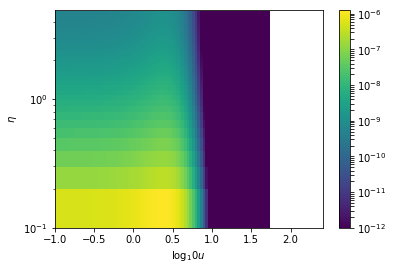

In [81]:
vis_nu = Vnu(0.25, 1600., mu1, f, u) 
power, eta = power_from_vis(vis_nu, f, nu0)
plot_power(power,u,eta,vmin=1e-12)

For a smaller beam (i.e. SKA-like):

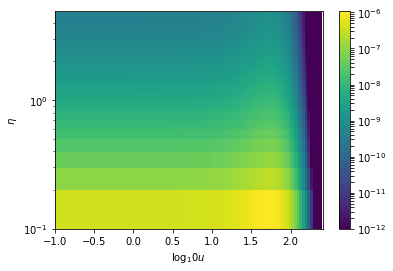

In [83]:
vis_nu = Vnu(0.025**2, 1600., mu1, f, u) 
power, eta = power_from_vis(vis_nu, f, nu0)
plot_power(power,u,eta,vmin=1e-12)

There is a slight wedge here, but it is very damped. This may be because of the infinite layout, *or* it may be because the sky is completely uniform. This second assumption we'll tackle next.

### Sky-Distribution: Stochastic  Uniform

** See the Top-Hat section corresponding to this to see the derivation of the basic equations **

In this case, where the beam is a gaussian, it can be removed and the integral over $\mathbf{l}$ performed immediately:

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \sum_{i_1=1}^{N_{\rm bl}}\sum_{i_2=1}^{N_{\rm bl}} \frac{\mu_2 \nu_0^2 y^2}{2} \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \frac{W'(\mathbf{u} - f'\mathbf{u}_{i_1}) W''(\mathbf{u} - f''\mathbf{u}_{i_2})}{\sum_{k=1}^{N_{\rm bl}}W'(\mathbf{u} - f' \mathbf{u}_k)\sum_{k=1}^{N_{\rm bl}}W''(\mathbf{u} - f'' \mathbf{u}_k)} \exp\left[-\sigma^2(f'\mathbf{u}_{i_1} -f'' \mathbf{u}_{i_2})^2)\right].
\end{equation}

#### Gridding: Dirac Delta

It is clear that this will end up with a dirac function at $\eta = 0$ (see top-hat corresponding section).

#### Gridding: NGP

(See corresponding section under single-source dist. for details of assumptions here).

In this case then we have $\mathbf{u}_i = \mathbf{u}$ and $W = 1$, and since the original baselines *must* be $\mathbf{u}$, we have:

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \pi \mu_2 \sigma^2 \nu_0^2 \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} e^{-\sigma^2 f_\nu^2 u^2},
\end{equation}

with $f_\nu = f'-f''$.

It is worth deriving this case fully for a gaussian taper/bandpass. The algebra gets a little tedious, but we can use Wolfram|Alpha as a two-step process to get the doube integral.

We let $q^2 = \sigma^2 u^2$,and $\omega = 2\pi \nu_0\eta$, for clarity, and find 

$$ Var(V) = \frac{2\pi^2 \mu_2 \sigma^2 \nu_0^2 \tau^2}{\sqrt{4q^2\tau^2 + 1}} \exp\left(-\frac{\tau^2 \omega^2}{4q^2 \tau^2 + 1}\right). $$

#### Gridding: Weighted

We begin with

\begin{equation}
    {\rm Var}\left(\tilde{V}(\eta, \mathbf{u})\right) = \sum_{i_1=1}^{N_{\rm bl}}\sum_{i_2=1}^{N_{\rm bl}} \frac{\mu_2 \nu_0^2 y^2}{2} \int d f' e^{-2\pi i f' \nu_0 \eta} \int df'' e^{+2\pi i f'' \nu_0 \eta} \frac{\hat{B}(\mathbf{u} - f'\mathbf{u}_{i_1}) \hat{B}(\mathbf{u} - f''\mathbf{u}_{i_2})}{\sum_{k=1}^{N_{\rm bl}}\hat{B}(\mathbf{u} - f' \mathbf{u}_k)\sum_{k=1}^{N_{\rm bl}}\hat{B}(\mathbf{u} - f'' \mathbf{u}_k)} \exp\left[-\sigma^2(f'\mathbf{u}_{i_1} -f'' \mathbf{u}_{i_2})^2)\right],
\end{equation}

with $\hat{B} \propto e^{-\pi y^2 u^2}$.

##### Baseline Layout: Symmetric Gaussian

Let the baseline layout (number density) be 

$$\rho(u_i) \propto e^{-u_i^2/2\sigma_u^2}. $$

Then the sum over baselines may be converted to an integral.

Again the integral in the denominator is:

$$\int d^2\mathbf{u}_i e^{-u_i^2/2\sigma_u^2}\hat{B}(\mathbf{u} - f \mathbf{u}_i) = e^{-\pi y^2 u^2}\left(\frac{\pi}{1/2\sigma_u^2 + \pi y^2f^2}\right)\exp\left(\frac{\pi^2y^4f^2u^2}{1/2\sigma_u^2 + \pi y^2f^2}\right). $$

In [6]:
from scipy.integrate import simps
from scipy.special import comb

In [7]:
comb?

In [23]:
x = np.linspace(0,2*np.pi, 1000)
n = 3
a = 0.001
ne = 1
ul = 1

y = np.cos(x)**(2*n)
yy = np.exp(-a*(ne + ul*x)**2)

print simps(y,x), simps(yy,x)

1.9634952841 6.15676388823


In [22]:
2*np.pi * comb(2*n,n)/4**n, 1 - a*(ne**2 + 0.5*ul**2)

(1.9634954084936207, 0.985)

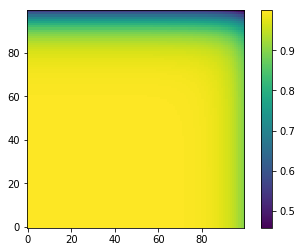

In [18]:
u = np.logspace(0,3,100)
eta = np.logspace(-3,0,100)

nu0 = 150.0
l0 = 0.1
tau = 1e3

U,ETA = np.meshgrid(u,eta)
plt.imshow(1 - 2*np.pi**2 * ((nu0*ETA)**2 + 0.5*(U*l0)**2)/tau**2,
          origin='lower')
plt.colorbar()